In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50

In [ ]:
# Path to the dataset
data_path = '/kaggle/input/faces-cvpr/Faces/'

# List the categories (folders) in the data path
categories = [folder for folder in os.listdir(data_path) if folder != "img"]
print(categories)

['Abir', 'Tishad', 'Touhid', 'Shimla']


In [ ]:
#Prepare the training data
train_data = []

# Limit the number of images per class
max_images_per_class = 1000

for c in categories:
    path = os.path.join(data_path, c)
    class_index = categories.index(c)
    count = 0  # Counter for the current class

    for img in tqdm(os.listdir(path)):
        if count >= max_images_per_class:  # Stop after max_images_per_class images
            break

        try:
            # Read the image in grayscale
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            # Normalize and resize the image
            img_arr = img_arr / 255.0  # Normalize to range [0, 1]
            img_arr = cv2.resize(img_arr, (256, 256))
            # Convert grayscale to RGB by stacking
            img_arr_rgb = np.stack((img_arr, img_arr, img_arr), axis=-1)
            # Append the image and its class label to the training data
            train_data.append([img_arr_rgb, class_index])
            count += 1  # Increment the counter
        except Exception as e:
            print(f"Error processing image {img}: {e}")

print(f"Total training samples: {len(train_data)}")


 33%|███▎      | 1000/3030 [00:04<00:09, 205.88it/s]

Total training samples: 4000


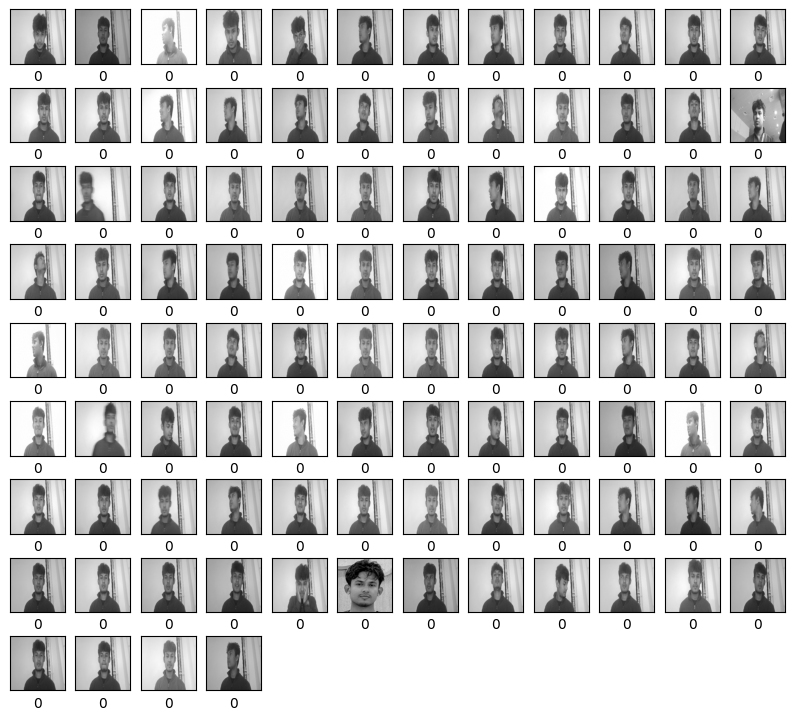

In [ ]:
# Plot a subset of images
plt.figure(figsize=(10,10))
i = 0
for r in range(10):
    for c in range(10):
        plt.subplot(10, 12, i + 1)
        plt.imshow(train_data[i][0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(train_data[i][1])
        i += 1
plt.show()

In [ ]:
# Prepare the data for training
np.random.shuffle(train_data)
X, y = zip(*train_data)
X = np.array(X, dtype=np.float32) / 255.0  # Normalize the images
y = np.array(y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

# One-hot encode the labels for multi-class classification
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

Training data shape: (3200, 256, 256, 3), Validation data shape: (800, 256, 256, 3)


In [ ]:
# Pre-trained ResNet50 model without the top layer
input_shape = (256, 256, 3)  # Input shape for ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # 4 classes, softmax activation

In [ ]:
# Define the model
from tensorflow.keras.models import Model
model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 158,520,516 (604.71 MB)

 Trainable params: 134,932,804 (514.73 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.2412 - loss: 5.2544 - val_accuracy: 0.2463 - val_loss: 1.5564
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.2389 - loss: 1.5501 - val_accuracy: 0.2387 - val_loss: 1.4054
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.2520 - loss: 1.4201 - val_accuracy: 0.2463 - val_loss: 1.3965
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.2405 - loss: 1.4088 - val_accuracy: 0.2463 - val_loss: 1.3881
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.2366 - loss: 1.4025 - val_accuracy: 0.2387 - val_loss: 1.4158
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.2224 - loss: 1.4011 - val_accuracy: 0.2387 - val_loss: 1.3897
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.2716 - loss: 1.3927 - val_accuracy: 0.2512 - val_loss: 1.3920
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.2501 - loss: 1

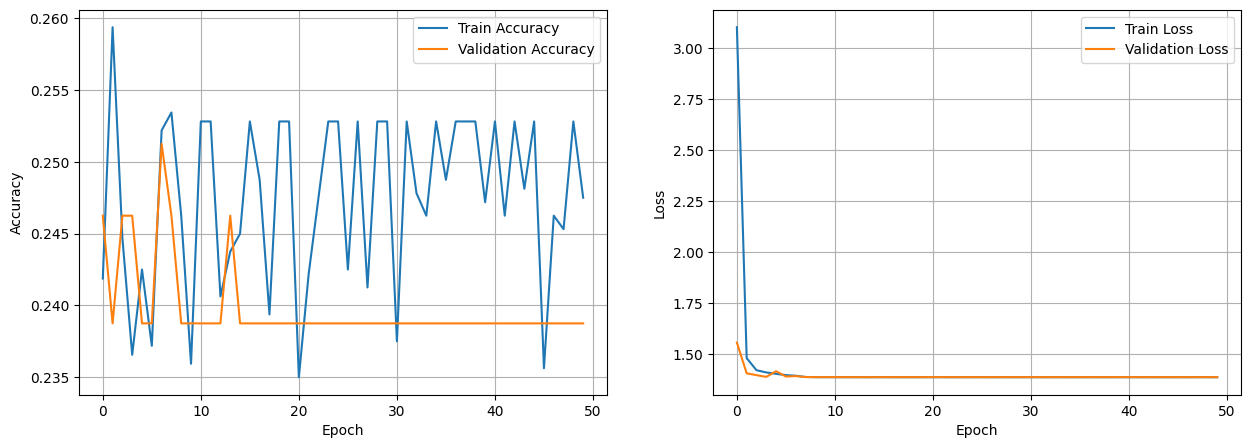

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.save("Transferlearning.h5")